### Machine Learning time!

Experiment between 3D values and perhaps 4D.

Intuition from exploratory analysis:

Certain combinations of yellow-blue, green-red parameters actually 'stretch' the data to fit a
"2D plane"-like structure.

In fact, it resembles a 'colour wheel' like gradient.

We might get the best results from these '2d plane' combinations with a 4th dimension like lighting 
in order to 'stretch' the plane in the 4th dimension to separate the noise-filled center where colors like
grey, silver and white are all co-located.

### Metrics

Type i errors (false positives) are more important. 
If we have many false positives, the prediction will be useless.
It is OK to have false negatives, as it will be considered "noise"


In [4]:
# Bootstrap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn

LABELS = [
    "Black",
    "Brown",
    "Red",
    "Orange",
    "Yellow",
    "Green",
    "Blue",
    "Purple",
    "Gray",
    "Silver",
    "Gold",
    "White",
    "Noise"
    ]

LABEL_UNKNOWN = "_Unknown"
FILEPATH_LABEL_CSV = "data/training/"
# df = pd.read_csv(FILEPATH_LABEL_CSV + "labels_2023-06-24_cleaned.csv")
df = pd.read_csv(FILEPATH_LABEL_CSV + "labels_2023-07-24.csv")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import joblib
label_encoder = LabelEncoder()

labels = np.append(df['label'].unique(), LABEL_UNKNOWN)
label_encoder.fit(labels)
df['label_encoded'] = label_encoder.transform(df['label'])


print(label_encoder.classes_)
print("Saving label_encoder...")
joblib.dump(label_encoder, "./models/label_encoder.pkl")
X = df.drop(['label', 'label_encoded'], axis=1)  # Drop the 'label' column from X
y = df['label_encoded']  # Assign the 'label_encoded' column to y

# Split the data into training and temporary sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

# Further split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, shuffle=True)


['Black' 'Blue' 'Brown' 'Gold' 'Green' 'Grey' 'Noise' 'Orange' 'Purple'
 'Red' 'Silver' 'White' 'Yellow' '_Unknown']
Saving label_encoder...


In [6]:
# Utils and metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import joblib
def filter_columns(mat, selected_columns):
    return mat.loc[:, selected_columns]

# Calculates the OvR AUC score and returns a list of scores for each label
def calculate_roc_ovr(y_pred_prob, y_true, label_encoder):
    # Compute AUC score
    roc_auc_scores = []
    for class_idx in range(0, len(label_encoder.classes_)):
        y_true = (y_val == class_idx)  # Convert true labels to binary for the current class
        y_scores = y_pred_prob[:, class_idx]  # Get the predicted probabilities or decision scores for the current class
        roc_auc = roc_auc_score(y_true, y_scores)
        roc_auc_scores.append(roc_auc)
    return roc_auc_scores

def print_roc_ovr(scores, label_encoder):
    for class_idx, roc_auc in enumerate(scores):
        print(f"Class {label_encoder.classes_[class_idx]}: ROC AUC = {roc_auc}")


def calculate_precision_recall(y_pred, y_true, label_encoder):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    precision_dict = dict(zip(label_encoder.classes_, precision))
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    recall_dict = dict(zip(label_encoder.classes_, recall))
    return (precision_dict, recall_dict)

def print_precision_recall(precision_dict:dict =None, recall_dict:dict =None):
    if precision_dict is not None:
        print("--- Precision Scores (~False Positive %) ---")
        for k, v in precision_dict.items():
            print(f"{k}: {v:.2f}") 
    if recall_dict is not None:
        print("--- Recall Scores (~False Negative %) ---")
        for k, v in recall_dict.items():
            print(f"{k}: {v:.2f}") 

def process_probability(y_pred, threshold:float, label_encoder):
    y_pred_labels = []
    for p_list in y_pred:
        max_prob = np.max(p_list)
        predicted = ''
        if max_prob >= threshold:
            max_prob_index = np.argmax(p_list)
            predicted = max_prob_index
        else:
            predicted = label_encoder.transform([LABEL_UNKNOWN])[0]
        y_pred_labels.append(predicted)
    return y_pred_labels

# Takes in the precision, recall and confusion matrices and do some stats
# Statistics to consider: 
# min <metric>
# avg <metric>
# % useless (how many datapoints thrown away?)
# returns ["pr_min", "pr_min_color", "pr_avg", "rc_min", "rc_min_color", "rc_avg", "useless"]
def precision_recall_stats(confusion_matrix:np.ndarray, precision_dict: dict, recall_dict: dict):
    # remove LABEL_UNKNOWN
    if precision_dict.get(LABEL_UNKNOWN) is not None:
        precision_dict.pop(LABEL_UNKNOWN)
    if recall_dict.get(LABEL_UNKNOWN) is not None:
        recall_dict.pop(LABEL_UNKNOWN)
    
    # sum(unknown)/total_samples
    useless = np.sum(confusion_matrix[:,-1])/ np.sum(confusion_matrix)
    pr_min_color, pr_min = min(precision_dict.items(), key=lambda item: item[1])
    pr_avg = np.average(list(precision_dict.values()))
    rc_min_color, rc_min = min(recall_dict.items(), key=lambda item: item[1])
    rc_avg = np.average(list(recall_dict.values()))

    # Populate the dict
    data = {
        'useless': useless,
        'pr_min_color': pr_min_color,
        'pr_min': pr_min,
        'pr_avg': pr_avg,
        'rc_min_color': rc_min_color,
        'rc_min': rc_min,
        'rc_avg': rc_avg
    }
    return data # prefer no-inline

# For statistical analysis of SVC hyperparameters
def build_precision_recall_dataframe():
    columns = ["colorspace", "degree", "regularization", 
        "pr_min", "pr_min_color", "pr_avg", "rc_min", "rc_min_color", "rc_avg", "useless"]
    stats_df = pd.DataFrame(columns=columns)
    return stats_df

def append_metadata(data:dict, colorspace:str=None, degree:int=None, regularization:float=None):
    if colorspace is not None:
        data["colorspace"] = colorspace
    if degree is not None:
        data["degree"] = degree
    if regularization is not None:
        data["regularization"] = regularization
    return data


--- Precision Scores (~False Positive %) ---
Black: 0.87
Blue: 0.89
Brown: 0.90
Gold: 0.79
Green: 1.00
Grey: 0.60
Noise: 0.86
Orange: 0.98
Purple: 0.98
Red: 1.00
Silver: 0.75
White: 0.89
Yellow: 0.88
_Unknown: 0.00
--- Recall Scores (~False Negative %) ---
Black: 0.84
Blue: 0.79
Brown: 0.80
Gold: 0.82
Green: 0.71
Grey: 0.16
Noise: 0.71
Orange: 0.83
Purple: 0.91
Red: 0.73
Silver: 0.70
White: 0.74
Yellow: 0.88
_Unknown: 0.00


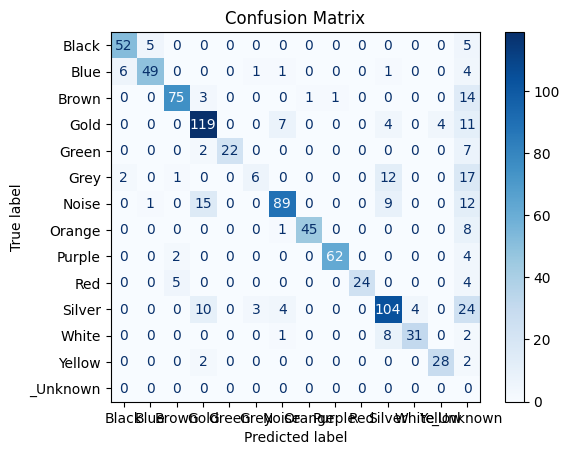

In [7]:
# SVM Bootstrap
# Get various metrics from the SVM results. Plot using RGB first.
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Train SVC based on some hyperparameters and benchmark against validation set
# Returns (confusion matrix, precision, recall)
def train_validate_classifier(X_train, y_train, X_val, y_val, colorspace,
                                regularization:float=2.0, degrees=3, prob_threshold=0.083):
    X_train_filt = filter_columns(X_train, colorspace)
    X_val_filt = filter_columns(X_val, colorspace)
    clf = svm.SVC(kernel='poly', probability=True,
                    degree=degrees, decision_function_shape='ovo', C=regularization)
    clf.fit(X_train_filt, y_train)

    y_pred_prob = clf.predict_proba(X_val_filt)
    y_pred = process_probability(y_pred_prob, prob_threshold, label_encoder)
    # --- METRICS CALCULATION ---
    cm = confusion_matrix(y_val, y_pred)
    precision, recall = calculate_precision_recall(y_pred, y_val, label_encoder)
    return (cm, precision, recall)

# Train and get Validation
cs = ['R', 'G', 'B']
cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val, cs, prob_threshold=0.5)
print_precision_recall(precision, recall)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Test stats logic
stats = precision_recall_stats(cm, precision, recall)


In [8]:
# Comparision between 3D color spaces
from itertools import combinations
print("EXPERIMENT 1: Stock SVM classifier with standard color spaces.")
colorspaces = [
    ["H","S","V"],
    ["R","G","B"],
    ["L",'a','b'],
    ["Y",'Cr','Cb']
    ]

exp1_df = build_precision_recall_dataframe()
exp1_data = []
for cs in colorspaces:
    cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val, cs)
    cs_name = ''.join(cs)
    data = precision_recall_stats(cm, precision, recall)
    data = append_metadata(data, colorspace=cs_name, degree=3, regularization=2)
    data_df = pd.DataFrame(data, index=[0])
    exp1_data.append(data_df)
exp1_df = pd.concat(exp1_data, ignore_index=True)
exp1_df.to_csv("./results/exp1.csv")
print(exp1_df)

EXPERIMENT 1: Stock SVM classifier with standard color spaces.
    useless pr_min_color    pr_min    pr_avg rc_min_color    rc_min    rc_avg  \
0  0.032051         Grey  0.580645  0.862139         Grey  0.473684  0.821242   
1  0.036325         Grey  0.636364  0.849117         Grey  0.368421  0.818191   
2  0.037393         Grey  0.560000  0.846684         Grey  0.368421  0.812682   
3  0.035256       Silver  0.738372  0.886345         Grey  0.578947  0.844080   

  colorspace  degree  regularization  
0        HSV       3               2  
1        RGB       3               2  
2        Lab       3               2  
3      YCrCb       3               2  


In [9]:
# Experiment 2: Exploring all possible 3D Spaces
print("EXPERIMENT 2: Stock SVM classifier with any 3 color spaces")
params = ['H','S','V','R','G','B','L','a','b','Y','Cr','Cb']
params = sorted(params)
combinations_list = list(combinations(params, 3))
exp2_df = build_precision_recall_dataframe()
exp2_data = []
for combo in combinations_list:
    cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val, combo)
    cs_name = ''.join(combo)
    data = precision_recall_stats(cm, precision, recall)
    data = append_metadata(data, colorspace=cs_name, degree=3, regularization=2)
    data_df = pd.DataFrame(data, index=[0])
    exp2_data.append(data_df)
exp2_df = pd.concat(exp2_data, ignore_index=True)
exp2_df = exp2_df.sort_values(by=["pr_avg", "pr_min"], ascending=[False, False])
print(exp2_df.head(10))
exp2_df.to_csv("./results/exp2.csv")

EXPERIMENT 2: Stock SVM classifier with any 3 color spaces
     useless pr_min_color    pr_min    pr_avg rc_min_color    rc_min  \
0   0.035256       Silver  0.750000  0.890675         Grey  0.578947   
66  0.035256       Silver  0.765823  0.888580         Grey  0.552632   
10  0.036325       Silver  0.746988  0.887097         Grey  0.526316   
16  0.036325       Silver  0.744048  0.886285         Grey  0.526316   
55  0.035256       Silver  0.736842  0.885723         Grey  0.578947   
60  0.035256       Silver  0.747059  0.885308         Grey  0.552632   
58  0.036325       Silver  0.741176  0.884969         Grey  0.526316   
61  0.035256       Silver  0.746988  0.884876         Grey  0.578947   
12  0.036325       Silver  0.773585  0.883955         Grey  0.526316   
87  0.036325       Silver  0.757764  0.883595         Grey  0.500000   

      rc_avg colorspace  degree  regularization  
0   0.852814      BCbCr       3               2  
66  0.851976       CbGR       3               2 

In [10]:
# Experiment 3: Exploring all possible 4D Spaces
# Our exploratory analysis tells us intuitively that 2D plane + lighting variable may be better
# eg: selected_parameters = ["a", 'Cb', 'Cr', "L"]
# But what if we explored all possible combinations?
print("EXPERIMENT 3: Stock SVM classifier with 4D color space")
def exp3():
    params = ['H','S','V','R','G','B','L','a','b','Y','Cr','Cb']
    params = sorted(params)
    combinations_list = list(combinations(params, 4))
    results = list() # { combo, accuracy }
    exp3_df = build_precision_recall_dataframe()
    exp3_data = []
    for combo in combinations_list:
        # adjust degree to 4 to fit number of dimensions
        cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val, combo, degrees=4)
        cs_name = ''.join(combo)
        data = precision_recall_stats(cm, precision, recall)
        data = append_metadata(data, colorspace=cs_name, degree=4, regularization=2)
        data_df = pd.DataFrame(data, index=[0])
        exp3_data.append(data_df)
    exp3_df = pd.concat(exp3_data, ignore_index=True)
    exp3_df = exp3_df.sort_values(by=["pr_avg", "pr_min", "useless"], ascending=[False, False, True])
    exp3_df.to_csv("./results/exp3.csv")
# exp3()
exp3_df = pd.read_csv("./results/exp3-1.csv")
print(exp3_df.head(20))

EXPERIMENT 3: Stock SVM classifier with 4D color space
      useless pr_min_color    pr_min    pr_avg rc_min_color    rc_min  \
192  0.034188       Silver  0.777778  0.899623         Grey  0.605263   
191  0.034188       Silver  0.764706  0.899098         Grey  0.578947   
4    0.036325       Silver  0.778443  0.898861         Grey  0.605263   
214  0.034188         Grey  0.766667  0.898770         Grey  0.605263   
72   0.034188       Silver  0.758824  0.897721         Grey  0.578947   
186  0.034188       Silver  0.751479  0.897152         Grey  0.526316   
168  0.036325       Silver  0.780488  0.895184         Grey  0.605263   
66   0.032051       Silver  0.739884  0.895110         Grey  0.526316   
345  0.033120       Silver  0.753086  0.893897         Grey  0.500000   
51   0.034188       Silver  0.759259  0.893431         Grey  0.552632   
303  0.033120         Grey  0.758621  0.893344         Grey  0.578947   
71   0.033120         Grey  0.733333  0.892998         Grey  0.578947

In [12]:
# Experiment 3-1: Choosing between 5D spaces
# We are potentially introducing alot of noise and unnecessary complexity
def exp3_1():
    print("EXPERIMENT 3-1: Stock SVM classifier with 5D color space")
    params = ['H','S','V','R','G','B','L','a','b','Y','Cr','Cb']
    combinations_list = list(combinations(params, 5))
    results = list() # { combo, accuracy }
    exp3_df = build_precision_recall_dataframe()
    exp3_data = []
    for combo in combinations_list:
        # adjust degree to 4 to fit number of dimensions
        cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val, combo, degrees=4)
        cs_name = ''.join(combo)
        data = precision_recall_stats(cm, precision, recall)
        data = append_metadata(data, colorspace=cs_name, degree=4, regularization=0.1)
        data_df = pd.DataFrame(data, index=[0])
        exp3_data.append(data_df)
    exp3_df = pd.concat(exp3_data, ignore_index=True)
    exp3_df = exp3_df.sort_values(by=["pr_avg", "pr_min", "useless"], ascending=[False, False, True])
    exp3_df.to_csv("./results/exp3-1.csv")
    print("Results saved")
# exp3_1()
exp3_1_df = pd.read_csv("./results/exp3-1.csv")
print(exp3_1_df.head(20))

    Unnamed: 0   useless pr_min_color    pr_min    pr_avg rc_min_color  \
0          649  0.030983       Silver  0.760479  0.908412         Grey   
1          646  0.029915       Silver  0.769697  0.907876        White   
2          610  0.028846         Grey  0.750000  0.904181        White   
3          524  0.029915       Silver  0.771930  0.903172        White   
4          564  0.027778       Silver  0.766467  0.902459         Grey   
5          413  0.029915       Silver  0.768786  0.902393        White   
6          378  0.028846         Grey  0.774194  0.901948        White   
7          629  0.028846       Silver  0.766467  0.901736         Grey   
8          656  0.029915       Silver  0.741176  0.901471        White   
9          650  0.028846         Grey  0.750000  0.901204        White   
10         603  0.026709       Silver  0.748503  0.901097        White   
11         606  0.026709       Silver  0.738095  0.900533         Grey   
12         311  0.027778       Silver 

In [ ]:
# EXPERIMENT 4: Choosing the best 4D Colorspace
# This may not be good for certain hyperparameters

def reset_train_val():
    return train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, shuffle=True)

params = ['H','S','V','R','G','B','L','a','b','Y','Cr','Cb']
params = sorted(params)
# the following is deterministic.
combinations_list = list(combinations(params, 4)) 
def experiment4():
    exp3_df = build_precision_recall_dataframe()
    exp3_data = []
    for combo in combinations_list:
        # adjust degree to 4 to fit number of dimensions
        cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val, combo, degrees=4)
        cs_name = ''.join(combo)
        data = precision_recall_stats(cm, precision, recall)
        data = append_metadata(data, colorspace=cs_name, degree=4, regularization=2)
        data_df = pd.DataFrame(data, index=[0])
        exp3_data.append(data_df)
    exp3_df = pd.concat(exp3_data, ignore_index=True)
    exp3_df = exp3_df.sort_values(by=["pr_avg", "pr_min", "useless"], ascending=[False, False, True])
    return exp3_df.head(10) 

def exp4():
    topCandidates = {}
    for i in range(0, 22):
        vals = experiment4()
        colorspaces = vals['colorspace']
        for v in colorspaces:
            topCandidates[v] = topCandidates.get(v, 0) + 1
    sorted_topCandidates = sorted(topCandidates.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(sorted_topCandidates, columns=['colorspace', 'count'])
    df.to_csv('./results/exp4.csv', index=False)  # Save the DataFrame to CSV without the index column
    print("Results saved!")
         
# exp4() # Use with caution - this takes VERY long
res = pd.read_csv('./results/exp4.csv')
print(res.head(10))

Results saved!
  colorspace  count
0     CbCrSY     22
1     CbCrVa     21
2      CrVYb     21
3     CbCrVY     21
4     CbCrGV     20
5     CbCrGb     19
6     CbCrVb     18
7     CbCrGS     17
8     CbCrRV     15
9      BCrVb     10


In [ ]:
# Experiment 5: Tuning hyperparameters
# Choose based on experimentation and intuition // CrCbHL
def exp5():
    colorspace = ["Cb", "Cr", "G", "H"]
    print("Experiment 5: Finding the best Poly kernel degree")
    exp5_df = build_precision_recall_dataframe()
    exp5_data = []
    for i in range(1,8):
        print("Gathering data for degree", i)
        for _ in range(22):
            X_train, X_val, y_train, y_val = reset_train_val()
            cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val, colorspace, degrees=i)
            cs_name = ''.join(combo)
            data = precision_recall_stats(cm, precision, recall)
            data = append_metadata(data, colorspace=cs_name, degree=i, regularization=2)
            data_df = pd.DataFrame(data, index=[0])
            exp5_data.append(data_df)
    exp5_df = pd.concat(exp5_data, ignore_index=True)
    exp5_df = exp5_df.sort_values(by=["pr_avg", "pr_min", "useless"], ascending=[False, False, True])
    exp5_df.to_csv("./results/exp5.csv")
    print("Results saved!")
# exp5()

Experiment 5: Finding the best Poly kernel degree
Gathering data for degree 1
Gathering data for degree 2
Gathering data for degree 3
Gathering data for degree 4
Gathering data for degree 5
Gathering data for degree 6
Gathering data for degree 7
Results saved!


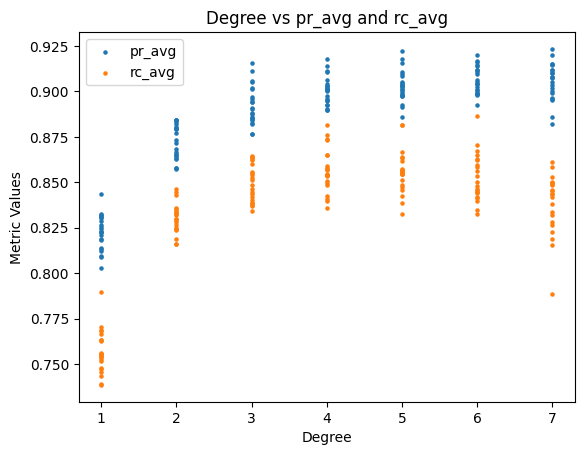

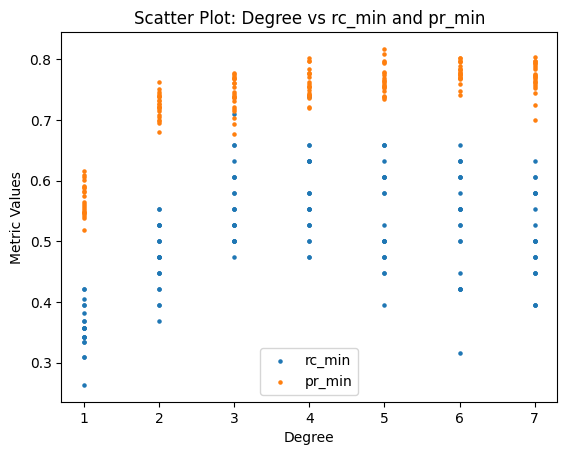

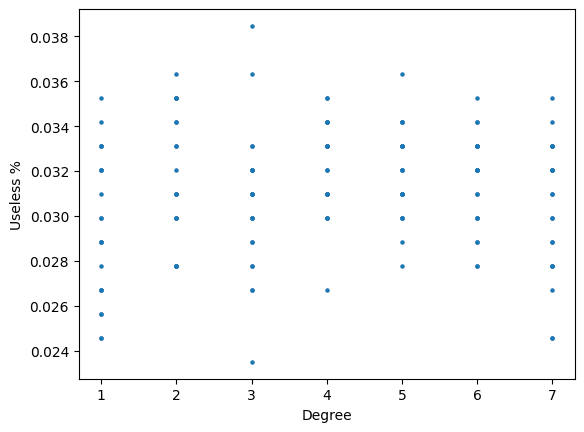

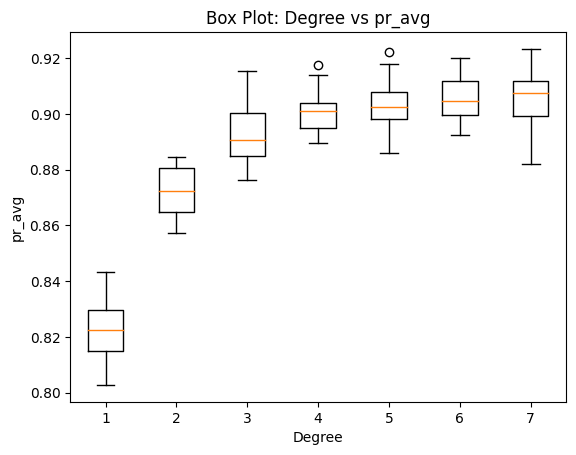

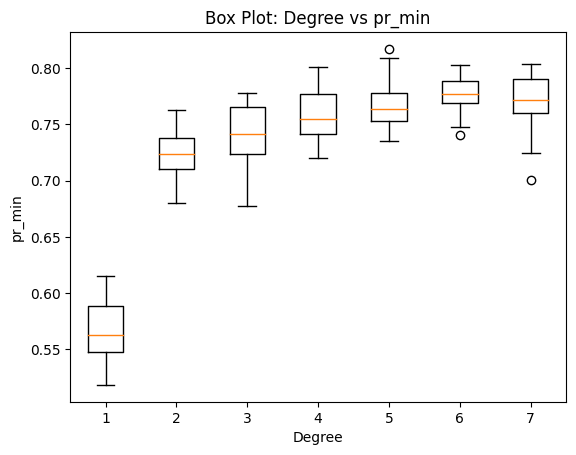

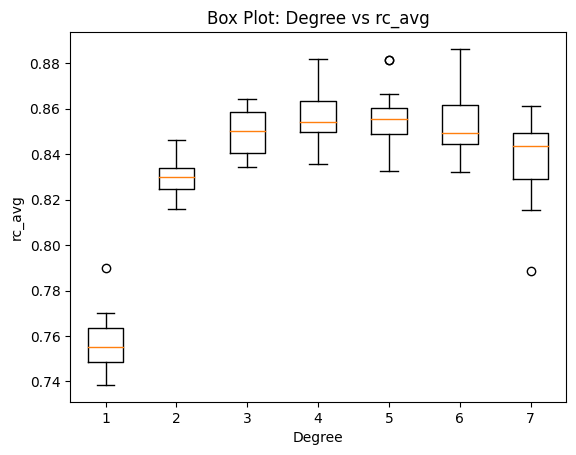

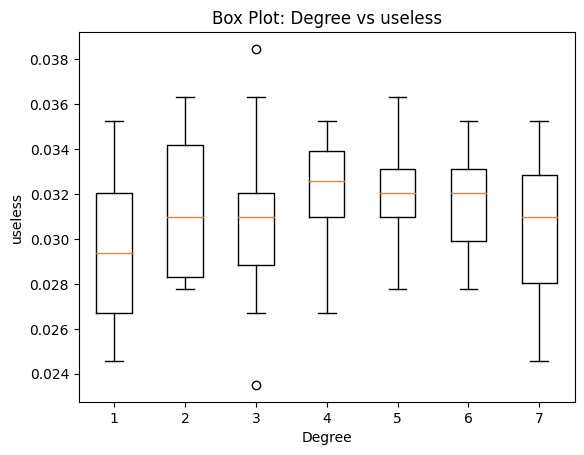

In [ ]:
exp5_df = pd.read_csv("./results/exp5.csv")

# Scatter plot: degree vs pr_avg and rc_avg
plt.scatter(exp5_df['degree'], exp5_df['pr_avg'], label='pr_avg', s=5)
plt.scatter(exp5_df['degree'], exp5_df['rc_avg'], label='rc_avg', s=5)

# Set plot title and labels
plt.title('Degree vs pr_avg and rc_avg')
plt.xlabel('Degree')
plt.ylabel('Metric Values')
plt.legend()
plt.show()

# Scatter plot: degree vs rc_min and pr_min
plt.scatter(exp5_df['degree'], exp5_df['rc_min'], label='rc_min', s=5)
plt.scatter(exp5_df['degree'], exp5_df['pr_min'], label='pr_min', s=5)

# Set plot title and labels
plt.title('Scatter Plot: Degree vs rc_min and pr_min')
plt.xlabel('Degree')
plt.ylabel('Metric Values')

plt.legend()
plt.show()

plt.scatter(exp5_df['degree'], exp5_df['useless'], label='foo', s=5)
plt.xlabel('Degree')
plt.ylabel('Useless %')
# plt.scatter(exp5_df['degree'], exp5_df['pr_min'], label='pr_min')
plt.show()

# ---- BOXPLOT ----
# Group the data by degree
def boxplot_deg(exp5_df, column):
    grouped_data = exp5_df.groupby('degree')
    # Create an empty list to store the 'rc_avg' values for each degree
    data = []
    # Extract the unique degree values
    degrees = sorted(exp5_df['degree'].unique())
    # Iterate over each degree and collect the 'rc_avg' values
    for degree in degrees:
        group = grouped_data.get_group(degree)
        metric_values = group[column].dropna()  # Remove missing values
        data.append(metric_values)
    plt.boxplot(data, labels=degrees)
    plt.title(f'Box Plot: Degree vs {column}')
    plt.xlabel('Degree')
    plt.ylabel(column)
    plt.show()
boxplot_deg(exp5_df, 'pr_avg')
boxplot_deg(exp5_df, 'pr_min')
boxplot_deg(exp5_df, 'rc_avg')
boxplot_deg(exp5_df, 'useless')

In [ ]:
# Experiment 6: Tuning hyperparameters - Regularization
# Choose CrVab based on experimentation and intuition
colorspace = ["Cr", "Cb", "S", "Y"]
print("Experiment 6: Regularization")

def exp6():
    exp6_df = build_precision_recall_dataframe()
    exp6_data = []
    reg = 0.01
    while reg < 3:
        reg += 0.01
        for _ in range(0,3):
            X_train, X_val, y_train, y_val = reset_train_val()
            cm, precision, recall = train_validate_classifier(X_train, y_train, X_val, y_val,
                                        colorspace, degrees=5, regularization = reg)
            cs_name = ''.join(combo)
            data = precision_recall_stats(cm, precision, recall)
            data = append_metadata(data, colorspace=cs_name, degree=5, regularization=reg)
            data_df = pd.DataFrame(data, index=[0])
            exp6_data.append(data_df)
    exp6_df = pd.concat(exp6_data, ignore_index=True)
    exp6_df = exp6_df.sort_values(by=["pr_avg", "pr_min", "useless"], ascending=[False, False, True])

    exp6_df.to_csv("./results/exp6.csv")
    print("Results saved")
# exp6()

Experiment 6: Regularization


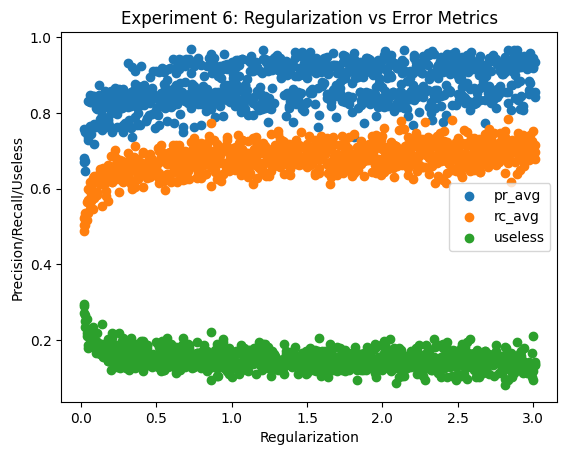

In [13]:
exp6_df = pd.read_csv("./results/exp6.csv")

# Scatter plot: degree vs pr_avg and rc_avg
plt.scatter(exp6_df['regularization'], exp6_df['pr_avg'], label='pr_avg')
plt.scatter(exp6_df['regularization'], exp6_df['rc_avg'], label='rc_avg')
plt.scatter(exp6_df['regularization'], exp6_df['useless'], label='useless')

# Set plot title and labels
plt.title('Experiment 6: Regularization vs Error Metrics')
plt.xlabel('Regularization')
plt.ylabel('Precision/Recall/Useless')
plt.legend()
plt.show()

# Conclusions

Based on the experiments, we can conclude the following parameters are sufficient for our colour prediction purposes.

1. 6 Degree Polynomial Kernel (might be overfitting)
2. 2.0 Regularization 
3. CbCrSY combined colorspace


Building production classifier...
Key metrics against test set:


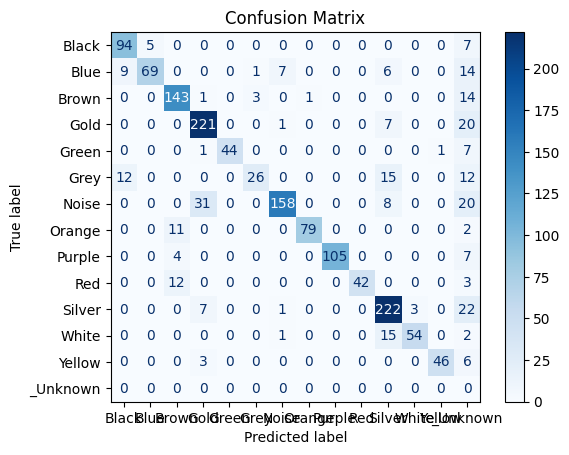

useless 0.08473520249221184
pr_min_color Silver
pr_min 0.8131868131868132
pr_avg 0.9201571473174869
rc_min_color Grey
rc_min 0.4
rc_avg 0.7864587246503141
Saving classifier as clf_20230724


['./models/clf_CbCrSY_20230724.pkl']

In [17]:
# Build the final classifier
import datetime
import joblib

DEGREES = 6
REGULARIZATION = 2.0
COLORSPACES = ["Cb", "Cr", "S", "Y"]
COLORSPACE_NAME = "CbCrSY"
PROB_THRESHOLD = 0.5 # Probability should be better than randomly choosing 1 of 12 labels
print("Building production classifier...")
X_train_filt = filter_columns(X_train, COLORSPACES)
X_test_filt = filter_columns(X_test, COLORSPACES)
clf = svm.SVC(kernel='poly', probability=True,
    degree=DEGREES, decision_function_shape='ovo', C=REGULARIZATION)
clf.fit(X_train_filt, y_train)

y_pred_prob = clf.predict_proba(X_test_filt)
y_pred = process_probability(y_pred_prob, PROB_THRESHOLD, label_encoder)

# --- METRICS CALCULATION ---
cm = confusion_matrix(y_test, y_pred)
precision, recall = calculate_precision_recall(y_pred, y_test, label_encoder)
stats = precision_recall_stats(cm, precision, recall)
# --- METRICS VISUALIZATION ---
print("Key metrics against test set:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
for key, value in stats.items():
    print(key, value)
current_date = datetime.datetime.now().strftime("%Y%m%d")
filename = f"clf_{COLORSPACE_NAME}_{current_date}.pkl"
print("Saving classifier as clf_"+ current_date)
joblib.dump(clf, "./models/"+filename)